- https://superuser.com/a/545692
- https://stackoverflow.com/questions/42097053/matplotlib-cannot-find-basic-fonts
- `sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng`
- `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
- `pip install latex`
- `import matplotlib.font_manager`
- `pip install git+https://github.com/nsh87/regressors.git@3a39e6aeb09953ccaeabec346f2eef324b7fcab9`

In [6]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from os import path,listdir
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import json 
import itertools

import networkx as nx

import pickle

from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import MultiTaskLasso,RidgeClassifier,LogisticRegression

from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score,  multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from regressors import stats as regstats
import statsmodels.api as sm

pd.options.display.max_columns = 500
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision_micro': make_scorer(precision_score, average='micro'),
           'recall_micro': make_scorer(recall_score, average='micro'),
           'f1_micro': make_scorer(f1_score, average='micro'),
           }


def accuracy_label_mean(a,b):
    A = a.copy()
    B = b.copy()
    XNOR = np.logical_not(np.logical_xor(A, B)).astype(int)    
    XNOR = pd.DataFrame(XNOR) 
    return XNOR.mean().to_frame().reset_index()[0].mean()

def accuracy_label_all(a,b):
    A = a.copy()
    B = b.copy()
    XNOR = np.logical_not(np.logical_xor(A, B)).astype(int)    
    XNOR = pd.DataFrame(XNOR) 
    return XNOR.mean().to_frame().to_dict()[0]

def hdmatrix(a,b,columns=None,title='',pdf=None,figsize=(10,10),hue_map=None):
    sns.set_style('white')
    # A = pd.DataFrame(A)
    # B = pd.DataFrame(B)
    A = a.copy()
    B = b.copy()
    XNOR = np.logical_not(np.logical_xor(A, B)).astype(int)    
    XNOR = pd.DataFrame(XNOR)    
    if columns is not None:
        XNOR.columns = columns
    _unique = np.unique(XNOR)
    if len(_unique)==2:
        cmap = ListedColormap(['#F08080', 'darkgreen'])
    elif _unique[0]==0:
        cmap = ListedColormap(['#F08080'])
    else:
        cmap = ListedColormap(['darkgreen'])
        
    L = A.shape[0]*A.shape[1]
    HAMMING = XNOR.values.sum()/L
    JACCARD = np.logical_and(A, B).astype(int).values.sum()/np.logical_or(A, B).astype(int).values.sum()
    F1=f1_score(A,B,average='micro')
    

    XNOR['all_ones'] = XNOR.eq(1).all(axis=1)
    ### TODO: fix extreme case: all correct or all incorrect.    
    plt.close('all')
    g = sns.clustermap(XNOR.drop('all_ones', axis=1), row_cluster=True, col_cluster=True,figsize=figsize)
    plt.close('all')
    row_order = g.dendrogram_row.reordered_ind
    df_reordered = XNOR.iloc[row_order].sort_values('all_ones', ascending=False).drop('all_ones', axis=1)
    all_ones = XNOR[XNOR['all_ones']]
    ACC = (len(all_ones) / len(XNOR))
    if hue_map is not None:
        df_reordered.columns = [hue_map.get(x,x.title()) for x in df_reordered.columns]
    cluster = sns.clustermap(df_reordered, row_cluster=False, col_cluster=True,
                             cmap=cmap,                             
                             dendrogram_ratio=(0.15, 0.01), 
                             figsize=figsize,
                             xticklabels=True, yticklabels=False,)
    cluster.ax_row_dendrogram.set_visible(False)
    cluster.ax_col_dendrogram.set_visible(False)
    
    colorbar = cluster.ax_heatmap.collections[0].colorbar
    if len(_unique)==2:
        colorbar.set_ticks([0.25, 0.75])
        colorbar.set_ticklabels(['False', 'True'])
        y_cbar_text = -.1
    else:
        colorbar.set_ticks([1])
        colorbar.set_ticklabels([('False' if _unique[0]==0 else 'True')])
        y_cbar_text = .88
    cluster.ax_cbar.text(0,y_cbar_text,'F1=%.2f\nACC=%.2f\nHD=%.2f\nJ=%.2f'%(F1,ACC,HAMMING,JACCARD),va='top')
    cluster.tick_params(axis='x', which='major', labelsize=10, 
                            labelbottom = False, bottom=False, top = True, labeltop=True)
    plt.setp(cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=20, va='bottom',ha='left')
    plt.suptitle(title,y=1.1)
    rect = plt.Rectangle((0, 0), cluster.ax_heatmap.get_xlim()[1]-.01, len(all_ones), lw=2, edgecolor='darkblue', facecolor='none')
    cluster.ax_heatmap.add_patch(rect)
    # plt.tight_layout()
    if pdf is not None:
        pdf.savefig(cluster.fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def feature_importance(X_train,y_train,clf,pdf=None,title='',figsize=(10,5)):
    sns.set_style('white')
    n_features = X_train.shape[1]
    _labels = list(y_train.columns)
    n_labels = len(_labels)
    feature_importances = np.zeros((n_labels, n_features))
    for i, label in enumerate(_labels):
        estimator = clf.estimators_[i]
        feature_importances[i] = estimator.feature_importances_

    zz = pd.DataFrame(feature_importances)
    zz.columns = [x.replace('ft_','') for x in X_train.columns]
    zz['label'] = [x.replace('LABEL_','').replace('GROUP_','') for x in _labels]
    zz.set_index('label',inplace=True)
    _ = zz.sum().to_dict()
    zz = zz[sorted(zz.columns,key=lambda x:-_[x])]
    fig,ax = plt.subplots(figsize=figsize)            
    sns.heatmap(zz,cmap='viridis',ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=10, labelleft=True,rotation=0)
    ax.set_ylabel('')
    plt.suptitle(title,y=1.18,fontsize=14)
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def plot_multilabel_roc(classifier, X_test, y_test, figsize=(6,6),title='ROC',hue_map=None,pdf=None):
    sns.set_style('whitegrid')
    _labels = list(y_test.columns)
    rocs = {}
    fprs = []
    tprs = []
    for i in range(y_test.shape[1]):        
        if hasattr(classifier.estimators_[i], "predict_proba"):
            y_score = classifier.estimators_[i].predict_proba(X_test)[:, 1]
        elif hasattr(classifier.estimators_[i], "decision_function"):  # Use decision function
            y_score = classifier.estimators_[i].decision_function(X_test)
        else:
            raise AttributeError("The base estimator doesn't have predict_proba or decision_function method.")        
        fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score)
        roc_auc = auc(fpr, tpr)
        rocs[_labels[i]]=roc_auc        
        fprs.append(fpr)
        tprs.append(tpr)
    order_idx = sorted(range(len(_labels)),key=lambda x:-rocs[_labels[x]])
    print(rocs)
    print(order_idx)
    fig,ax = plt.subplots(figsize=figsize)
    cmap = mpl.cm.get_cmap('tab20')
    label_colors = {x:cmap(idx%20) for idx,x in enumerate(_labels)}    
    for idx in order_idx:
        fancy_label = _labels[idx]
        if hue_map is not None:
            fancy_label = fancy_label.replace('LABEL_','').replace('GROUP_','')
            fancy_label = hue_map.get(fancy_label,fancy_label.title())
        ax.plot(fprs[idx], tprs[idx], lw=2, 
                label='{0} (AUC = {1:0.2f})'.format(fancy_label, rocs[_labels[idx]]))
    plt.plot([0, 1], [0, 1], 'k--', lw=1)        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    # return rocs,[_labels[i] for i in order_idx]
    return rocs,order_idx

    
def plot_confusion_matrices(y_test,y_pred,title='',pdf=None,hue_order=None,hue_map=None):
    sns.set_style('white')
    _labels = list(y_test.columns)
    cm = multilabel_confusion_matrix(y_test, y_pred)
    ncols = 4
    nrows = int(np.ceil(len(cm)/ncols))
    blank = (ncols*nrows)-len(cm)
    fig,axs =plt.subplots(figsize=(11,2.5*nrows),ncols=ncols,nrows=nrows)
    axs = axs.flatten()
    if hue_order is not None:
        iterlist = hue_order
    else:
        iterlist = list(range(len(cm)))
    for IDX,i in enumerate(iterlist):
        ax = axs[IDX]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[0,1])
        disp.plot(cmap='Blues',ax=ax)
        _title = _labels[i].replace('LABEL_','').replace('GROUP_','')
        if hue_map is not None:
            _title = hue_map.get(_title,_title.title())
        ax.set_title(f'{_title}',fontsize=10,fontweight='bold')
        if IDX%ncols!=0:
            ax.set_ylabel('')        
            ax.set_yticks([])
        if blank>0 and (IDX//ncols)==(nrows-2):
            if (ncols-(IDX%ncols))<=blank:
                continue
        if (IDX//ncols)!=(nrows-1):
            ax.set_xlabel('')        
            ax.set_xticks([])
    for i in range(len(cm),(ncols*nrows)):
        axs[i].axis('off')

    plt.suptitle(title,y=0.98,fontsize=14)
    # plt.subplots_adjust(wspace=0.15,hspace=0.32)
    plt.tight_layout()
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def plot_groups_diagram(groups,cols_labels_full,cols_labels,pdf=None,figsize=(12,10),dpi=75,X_RECT1 = 1150, X_RECT2 = 1320):
    sns.set_style('white')
    # Define the graph
    not_included = [x.replace('LABEL_','') for x in sorted(set(cols_labels_full)-set(cols_labels))]

    G = nx.DiGraph()
    # Add nodes
    G.add_node("Groups")
    for k,v in groups.items():
        k2 = k.replace('GROUP_','')
        G.add_edge('Groups',k2)
        for u in  v:
            u2 = u.replace('LABEL_','')
            if k2==u2:
                u2=u2+'.'
            G.add_edge(k2,u2)
    # if len(not_included)>0:
    #     G.add_edge('Groups','Not included:')

    # Plot the graph
    fig,ax = plt.subplots(figsize=figsize,dpi=dpi)
    # pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
    nx.draw_networkx_nodes(G, pos, linewidths=1, node_size=0, node_color="white", 
                           edgecolors="none",margins=(0.02,.2),ax=ax)
    nx.draw_networkx_edges(G, pos, width=1, edge_color="black", arrowstyle="->",ax=ax,min_source_margin=35,min_target_margin=35)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="normal", ax=ax,verticalalignment='center')

#     _patches = []
#     ax.text(0,pos[k2][1]+10,'Groups',ha='left',va='bottom',color='black',weight='bold')
#     rect = patches.Rectangle((0, pos[k2][1]-5), X_RECT1, 12, linewidth=1, edgecolor='none', facecolor='red',alpha=0.5)
#     _patches.append(rect)

#     ax.text(0,pos[u2][1]+10,'Bacteria',ha='left',va='bottom',color='black',weight='bold')
#     rect = patches.Rectangle((0, pos[u2][1]-5), X_RECT2, 12, linewidth=1, edgecolor='none', facecolor='darkorange',alpha=0.5)
#     _patches.append(rect)

#     for p in _patches:
#         ax.add_patch(p)

#     if len(not_included)>0:
#         ax.text(pos['Not included:'][0],pos['Not included:'][1]-5,'\n'.join(not_included),
#                 fontsize=8.5,ha='center',va='top',color='black')

    plt.axis("off")
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
    
def feature_importance2(X_train,y_train,X_test,y_test,y_pred,clf,pdf=None,title='',figsize=(10,5),hue_map=None,output_txt=None):
    sns.set_style('white')
    n_features = X_train.shape[1]
    _labels = list(y_train.columns)
    n_labels = len(_labels)
    feature_importances = np.zeros((n_labels, n_features))    
    for i, label in enumerate(_labels):
        estimator = clf.estimators_[i]
        feature_importances[i] = estimator.feature_importances_
        
    y_pred_prob = clf.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i,label in enumerate(_labels):
        fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred_prob[i][:, 1])
        roc_auc[label.replace('LABEL_','').replace('GROUP_','')] = np.round(auc(fpr[i], tpr[i]),2)    

    zz = pd.DataFrame(feature_importances)
    zz.columns = [x.replace('ft_','') for x in X_train.columns]
    zz['label'] = [x.replace('LABEL_','').replace('GROUP_','') for x in _labels]
    zz['auc'] = zz['label'].map(roc_auc)
    if hue_map is None:
        zz['label'] = zz.apply(lambda x:"%s (AUC=%.2f)"%(x['label'],x['auc']),axis=1)
    else:
        zz['label'] = zz.apply(lambda x:"%s (AUC=%.2f)"%(hue_map.get(x['label'],x['label']),x['auc']),axis=1)
    zz.sort_values(by='auc',ascending=False,inplace=True)
    zz.pop('auc')
    zz.set_index('label',inplace=True)
    # _ = zz.sum().to_dict()
    _ = zz.mean().to_dict()
    print(_)
    zz = zz[sorted(zz.columns,key=lambda x:-_[x])]
    if output_txt is not None:
        with open(output_txt,'w') as f:
            f.write('\n'.join(zz.columns))
        print('### Wrote',output_txt)
    
    fig,ax = plt.subplots(figsize=figsize)
    if hue_map is not None:
        zz.columns = [hue_map.get(x,x.title()) for x in zz.columns]
    sns.heatmap(zz,cmap='viridis',ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=10, labelleft=True,rotation=0)
    ax.set_ylabel('')
    plt.suptitle(title,fontsize=14)
    plt.tight_layout()
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def summary(clf, X, y, xlabels=None,display=False):
    """
    Output summary statistics for a fitted regression model.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    xlabels : list, tuple
        The labels for the predictors.
    """
    # Check and/or make xlabels
    ncols = X.shape[1]
    if xlabels is None:
        xlabels = np.array(
            ['x{0}'.format(i) for i in range(1, ncols + 1)], dtype='str')
    elif isinstance(xlabels, (tuple, list)):
        xlabels = np.array(xlabels, dtype='str')
    # Make sure dims of xlabels matches dims of X
    if xlabels.shape[0] != ncols:
        raise AssertionError(
            "Dimension of xlabels {0} does not match "
            "X {1}.".format(xlabels.shape, X.shape))
    # Create data frame of coefficient estimates and associated stats
    coef_df = pd.DataFrame(
        index=['_intercept'] + list(xlabels),
        columns=['Estimate', 'Std. Error', 't value', 'p value']
    )    
    try:
        coef_df['Estimate'] = np.concatenate(
            (np.round(np.array([clf.intercept_]), 6), 
             np.round((clf.coef_), 6)))
    except:
        coef_df['Estimate'] = np.concatenate(
            (
                np.round(np.array([clf.intercept_]), 6),
                np.round((clf.coef_), 6)
            ), axis = 1).T
    coef_df['Std. Error'] = np.round(regstats.coef_se(clf, X, y), 6)
    coef_df['t value'] = np.round(regstats.coef_tval(clf, X, y), 4)
    coef_df['p value'] = np.round(regstats.coef_pval(clf, X, y), 6)
    # Create data frame to summarize residuals
    resids = regstats.residuals(clf, X, y, r_type='raw')
    resids_df = pd.DataFrame({
        'Min': pd.Series(np.round(resids.min(), 4)),
        '1Q': pd.Series(np.round(np.percentile(resids, q=25), 4)),
        'Median': pd.Series(np.round(np.median(resids), 4)),
        '3Q': pd.Series(np.round(np.percentile(resids, q=75), 4)),
        'Max': pd.Series(np.round(resids.max(), 4)),
    }, columns=['Min', '1Q', 'Median', '3Q', 'Max'])
    # Output results
    if display:
        print("Residuals:")
        print(resids_df.to_string(index=False))
        print('\n')
        print('Coefficients:')
        print(coef_df.to_string(index=True))
        print('---')
        print('R-squared:  {0:.5f},    Adjusted R-squared:  {1:.5f}'.format(
            metrics.r2_score(y, clf.predict(X)), regstats.adj_r2_score(clf, X, y)))
        print('F-statistic: {0:.2f} on {1} features'.format(
            regstats.f_stat(clf, X, y), ncols))
    return coef_df

map_all = {'staphylococci':'$\it{Staphylococcus}$ spp.',
         'enterobacterales':'Enterobacterales',
         'enteros':'Enterobacterales',
         'fungi':'Fungi',
          'enterococci':'$\it{Enterococcus}$ spp.',
          'streptococci':'$\it{Streptococcus}$ spp.',
          'gram.neg':'Other Gram-negative bacteria',
          'anaerobic':'Anaerobic bacteria',
           'age':'Age',
           'duree':'Duration of surgery',
           'bmi':'BMI [kg/m²]',
           'surg':'Type of surgery',
           'asa':'ASA score',
           'class':'Wound contamination',
           'clindamycine':'Clindamycine',
           'cephalosporin.all':'Cephalosporine',
           'glycopeptide':'Glycopeptide',
           'quinolone':'Quinolone',
           'elective':'Elective procedure',
           'endo_2L':'Minimally invasive procedure',
           'nitroimidazole':'Nitroimidazole',
           'penicillin.all':'Penicilin',
           'carbapenem':'Carbapenem',
           'SAP.b':'SAP administered (yes / no)',
           'hosp_size':'Hospital size',
           'sex':'Sex',
           'other.SAP2':'Other SAP',
           'prev.hosp.b':'Hospitalization prior to surgery'}
map_all_inv = {v:k for k,v in map_all.items()}

# Variables

In [2]:
input_path = 'inputs'
output_path = 'outputs_september'
clean_train_csv = path.join(input_path,'scaled2.train.csv')
clean_test_csv = path.join(input_path,'scaled2.test.csv')
# clean_train_csv = path.join(input_path,'scaled.train.csv')
# clean_test_csv = path.join(input_path,'scaled.test.csv')

groups_name = 'groups9.csv'
groups_csv = path.join(input_path,groups_name)
output_test_groups = path.join(output_path,'output_test_'+groups_name)

# Load

In [3]:
df = pd.read_csv(clean_train_csv)
dfT = pd.read_csv(clean_test_csv)

df['_id'] = range(len(df))
dfT['_id'] = range(len(dfT))

cols_ft = [x for x in df.columns if x.startswith('ft_')]
cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
cols_labels_full = list(cols_labels)


print('\n'.join([x for x in cols_ft if x.startswith('ft_surg')]))

print('Full training:',len(df))
df.dropna(inplace=True)
print('dropna training:',len(df))

print('Full test:',len(dfT))
dfT.dropna(inplace=True)
print('dropna test:',len(dfT))

### Load groups
groups = {}
for g,d in pd.read_csv(groups_csv,sep=';').groupby('group'):
    groups['GROUP_'+g] = ['LABEL_'+x for x in d.bacteria]
print(groups)
present_labels = set(sum(list(groups.values()),[]))
all_labels = set(cols_labels)
cols_labels = sorted(present_labels)
print('> Columns to keep:',cols_labels)
print('> Columns to drop:', all_labels-present_labels)
for k,v in groups.items():
    df[k] = (df[v].sum(axis=1)>0).astype(int)
    dfT[k] = (dfT[v].sum(axis=1)>0).astype(int)
cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
df.drop(columns = all_labels-present_labels,inplace=True)
dfT.drop(columns = all_labels-present_labels,inplace=True)

###### Assign groups
df = df[df[cols_groups].sum(axis=1)>0]
dfT = dfT[dfT[cols_groups].sum(axis=1)>0]
print('After groups training:',len(df))
print('After groups test:',len(dfT))

ft_surg_Cholecystectomy
ft_surg_Colorectal surgery
ft_surg_Heart surgery
ft_surg_Hernia surgery
ft_surg_Hip replacement
ft_surg_Knee replacement
ft_surg_Spinal surgery
Full training: 5239
dropna training: 5239
Full test: 1363
dropna test: 1363
{'GROUP_anaerobic': ['LABEL_cutibacterium', 'LABEL_clostridium', 'LABEL_other.anaerobic', 'LABEL_bacteroides'], 'GROUP_enterobacterales': ['LABEL_e.coli', 'LABEL_klebsiella', 'LABEL_proteus', 'LABEL_serratia', 'LABEL_enterobacter', 'LABEL_other.enterobacteriacea'], 'GROUP_enterococci': ['LABEL_enterococci'], 'GROUP_fungi': ['LABEL_fungi'], 'GROUP_gram.neg': ['LABEL_pseudomonas', 'LABEL_other.gramneg'], 'GROUP_staphylococci': ['LABEL_staphylococci'], 'GROUP_streptococci': ['LABEL_streptococci']}
> Columns to keep: ['LABEL_bacteroides', 'LABEL_clostridium', 'LABEL_cutibacterium', 'LABEL_e.coli', 'LABEL_enterobacter', 'LABEL_enterococci', 'LABEL_fungi', 'LABEL_klebsiella', 'LABEL_other.anaerobic', 'LABEL_other.enterobacteriacea', 'LABEL_other.gramne

In [4]:
dfT.columns

Index(['ft_age', 'ft_bmi', 'ft_duree', 'ft_asa_1', 'ft_asa_2', 'ft_asa_3',
       'ft_asa_4', 'ft_asa_5', 'ft_class_Clean', 'ft_class_Clean-Contaminated',
       'ft_class_Contaminated', 'ft_class_Dirty/Infected',
       'ft_hosp_size_200-499', 'ft_hosp_size_500+', 'ft_hosp_size_<200',
       'ft_surg_Cholecystectomy', 'ft_surg_Colorectal surgery',
       'ft_surg_Heart surgery', 'ft_surg_Hernia surgery',
       'ft_surg_Hip replacement', 'ft_surg_Knee replacement',
       'ft_surg_Spinal surgery', 'ft_carbapenem', 'ft_cephalosporin.all',
       'ft_clindamycine', 'ft_elective', 'ft_endo_2L', 'ft_glycopeptide',
       'ft_implant', 'ft_nitroimidazole', 'ft_other.SAP2', 'ft_penicillin.all',
       'ft_prev.hosp.b', 'ft_quinolone', 'ft_SAP.b', 'ft_scoreT', 'ft_sex',
       'LABEL_staphylococci', 'LABEL_streptococci', 'LABEL_enterococci',
       'LABEL_e.coli', 'LABEL_klebsiella', 'LABEL_proteus', 'LABEL_serratia',
       'LABEL_enterobacter', 'LABEL_other.enterobacteriacea',
       'LABE

---
---
---
# Iterate over groups

In [ ]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'

INCLUDE_SURG=True
# INCLUDE_SURG=False


output_pdf = 'outputs_september/scaledresults_9.pdf'

surgery = None
surgery = 'ft_surg_Cholecystectomy'
surgery = 'ft_surg_Colorectal surgery'
surgery = 'ft_surg_Heart surgery'
surgery = 'ft_surg_Hernia surgery'
surgery = 'ft_surg_Hip replacement'
surgery = 'ft_surg_Knee replacement'
surgery = 'ft_surg_Spinal surgery'

if surgery is not None:
    output_pdf = output_pdf.replace('9.pdf',surgery.replace('ft_surg_','')+'.pdf')
    print(output_pdf)

if INCLUDE_SURG:
    output_pdf = output_pdf.replace('.pdf','_WITHSURGERY.pdf')
else:
    output_pdf = output_pdf.replace('.pdf','_NOSURGERY.pdf')

pdf = PdfPages(output_pdf)
# pdf = None
for i in range(9,10):
    
    groups_name = 'groups%d.csv'%i
    groups_csv = path.join(input_path,groups_name)
    fig,ax = plt.subplots(figsize=(5,5))
    ax.text(0.5,0.5,groups_name,ha='center',va='center',fontsize=22)
    ax.axis('off')
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    plt.close('all')

    df = pd.read_csv(clean_train_csv)    
    dfT = pd.read_csv(clean_test_csv)
    
    cols_ft = [x for x in df.columns if x.startswith('ft_')]
    cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
    cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])

    if surgery is not None:
        df = df[df[surgery]==1]
        dfT = dfT[dfT[surgery]==1]        
        print('!!!!!!!!!!!!!!!!!!!!!!!')
        a1= df[cols_labels].sum().to_frame().reset_index()
        a2= dfT[cols_labels].sum().to_frame().reset_index()
        to_remove = set(a1[a1[0]==0]['index'])|set(a2[a2[0]==0]['index'])
        print(to_remove)
        df.drop(columns=list(to_remove),inplace=True)
        dfT.drop(columns=list(to_remove),inplace=True)
        
    ###Correlation    
    corr = df.corr()    
    mask = np.triu(np.ones_like(corr, dtype=bool))    
    plt.figure(figsize=(12, 10))    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                xticklabels=True, yticklabels=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Heatmap')
    plt.show()
    
    ###TODO: REMOVE SURGERIES
    if not INCLUDE_SURG:
        df = df[[x for x in df.columns if not x.startswith('ft_surg_')]]
        dfT = dfT[[x for x in dfT.columns if not x.startswith('ft_surg_')]]
    else:
        pass
    
    df['_id'] = range(len(df))
    dfT['_id'] = range(len(dfT))

    cols_ft = [x for x in df.columns if x.startswith('ft_')]
    cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
    print('$$$$',cols_labels)
    cols_labels_full = list(cols_labels)

    print('Full training:',len(df))
    df.dropna(inplace=True)
    print('dropna training:',len(df))

    print('Full test:',len(dfT))
    dfT.dropna(inplace=True)
    print('dropna test:',len(dfT))

    ### Load groups
    groups = {}
    for g,d in pd.read_csv(groups_csv,sep=';').groupby('group'):
        groups['GROUP_'+g] = list(set(['LABEL_'+x for x in d.bacteria])&set(cols_labels)) ###sanity check for existing bacterial labels
    print(groups)
    present_labels = set(sum(list(groups.values()),[]))
    all_labels = set(cols_labels)
    cols_labels = sorted(present_labels)
    print('> Columns to keep:',cols_labels)
    print('> Columns to drop:', all_labels-present_labels)
    for k,v in groups.items():        
        df[k] = (df[v].sum(axis=1)>0).astype(int)
        dfT[k] = (dfT[v].sum(axis=1)>0).astype(int)
    cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
    df.drop(columns = all_labels-present_labels,inplace=True)
    dfT.drop(columns = all_labels-present_labels,inplace=True)

    ###### Assign groups
    df = df[df[cols_groups].sum(axis=1)>0]
    dfT = dfT[dfT[cols_groups].sum(axis=1)>0]
    print('+++++++++')
    a1= df[cols_groups].sum().to_frame().reset_index()
    a2= dfT[cols_groups].sum().to_frame().reset_index()
    to_remove = set(a1[a1[0]==0]['index'])|set(a2[a2[0]==0]['index'])
    print(to_remove)
    df.drop(columns=list(to_remove),inplace=True)
    dfT.drop(columns=list(to_remove),inplace=True)
    cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
    groups = {k:v for k,v in groups.items() if k in cols_groups}
    
    
    print('After groups training:',len(df))
    print('After groups test:',len(dfT))


    ### Plot diagrams
    plot_groups_diagram(groups,cols_labels_full,cols_labels,figsize=(12,10),dpi=75,pdf=pdf)

    ### Train models
    X_train = df[cols_ft]
    y_total = df[cols_labels]
    y_groups = df[cols_groups]
    X_test = dfT[cols_ft]
    y_test_total = dfT[cols_labels]
    y_test_groups = dfT[cols_groups]

    
    model1 = AdaBoostClassifier(random_state=42)
    model2 = AdaBoostClassifier(random_state=42)
    # model1 = RidgeClassifier(alpha=1,random_state=42)
    # model2 = RidgeClassifier(alpha=1,random_state=42)
    total_classifier = MultiOutputClassifier(model1).fit(X_train, y_total)
    group_classifier = MultiOutputClassifier(model2).fit(X_train, y_groups)
    print(total_classifier)
    y_total_pred = total_classifier.predict(X_test)
    y_groups_pred = group_classifier.predict(X_test)
    
    roc_groups,order_groups = plot_multilabel_roc(group_classifier, X_test, y_test_groups,hue_map=map_all,pdf=None)
    roc_total,order_bacteria = plot_multilabel_roc(total_classifier, X_test, y_test_total,hue_map=map_all,pdf=None)
    

    print('ROC groups:',roc_groups)
    print('ROC bacteria:',roc_total)
    
    pretty_groups = [x.replace('GROUP_','') for x in y_groups.columns]
    pretty_bacteria = [x.replace('LABEL_','') for x in y_total.columns]

    map_labels = {}    
    
    ####METRICS
    accuracy = accuracy_score(y_test_groups, y_groups_pred)
    precision = precision_score(y_test_groups, y_groups_pred, average='micro')
    recall = recall_score(y_test_groups, y_groups_pred, average='micro')
    f1 = f1_score(y_test_groups, y_groups_pred, average='micro')
    accuracy_label = accuracy_label_mean(y_test_groups, y_groups_pred)
    d = {'accuracy':round(accuracy,4),
         'accuracy_label':round(accuracy_label,4),
               'precision_micro':round(precision,4), 
               'recall_micro':round(recall,4),
               'f1_micro':round(f1,4)}
    print('##Wrote',output_pdf.replace('.pdf','.metrics'))
    with open(output_pdf.replace('.pdf','.metrics'),'w') as f:
        f.write(str(d))

    print('###ORDER BACTERIA:\n',order_bacteria)
    print('###ORDER GROUPS:\n',order_groups)

    ### Plot results
    figsize = (4.4,6.5)
    _figsize=(max(4.8,.5*len(cols_groups)),6.5)
    hdmatrix(y_test_groups,y_groups_pred,title="Groups - HD Matrix",columns=pretty_groups,figsize=_figsize,pdf=pdf,hue_map=map_all)    
    feature_importance2(X_train,y_groups,X_test,y_test_groups,y_groups_pred,group_classifier,
                        title='Groups - Feature importance',pdf=pdf,hue_map=map_all,output_txt='FT_ORDER.txt')    
    plot_multilabel_roc(group_classifier, X_test, y_test_groups,hue_map=map_all,pdf=pdf)
    plot_confusion_matrices(y_test_groups,y_groups_pred,title='Groups - Confusion matrices',pdf=pdf,hue_order=order_groups,hue_map=map_all)

    _figsize=(max(4.8,.5*len(cols_labels)),6.5)
    hdmatrix(y_test_total,y_total_pred,title='Bacteria - HD Matrix',columns=pretty_bacteria,figsize=_figsize,pdf=pdf,hue_map=map_all)    
    feature_importance2(X_train,y_total,X_test,y_test_total,y_total_pred,total_classifier,title='Bacteria - Feature importance',pdf=pdf,hue_map=map_all)    
    plot_multilabel_roc(total_classifier, X_test, y_test_total,hue_map=map_all,pdf=pdf)
    plot_confusion_matrices(y_test_total,y_total_pred,title='Bacteria - Confusion matrices',pdf=pdf,hue_order=order_bacteria,hue_map=map_all)

pdf.close()

In [7]:
output_groups = 'clf_group.model'
output_bacteria = 'clf_label.model'
with open(output_groups,'wb') as f:
    pickle.dump(group_classifier, f)
with open(output_bacteria,'wb') as f:
    pickle.dump(total_classifier, f)

In [46]:
# X_train2 = X_train
# features = list(X_train.columns)
# labels_groups = list(y_groups.columns)
# labels_total = list(y_total.columns)
# rows = []
# for i,e in enumerate(group_classifier.estimators_):
#     CC = summary(e, X_train2, y_groups.values[:,i],xlabels=list(X_train2.columns),display=False)
#     CC['level']='groups'
#     CC['name']=labels_groups[i]    
#     CC.drop(columns = ['Std. Error','t value'], inplace=True)
#     rows.append(CC)
        
# for i,e in enumerate(total_classifier.estimators_):
#     CC = summary(e, X_train2, y_total.values[:,i],xlabels=list(X_train2.columns),display=False)
#     CC['level']='bacteria'
#     CC['name']=labels_total[i]    
#     CC.drop(columns = ['Std. Error','t value'], inplace=True)
#     rows.append(CC)
    
# coef_df = pd.concat(rows)
# coef_df['name'] = coef_df['name'].str.replace('GROUP_','').str.replace('LABEL_','')
# coef_df['name'] = coef_df['name'].apply(lambda x:map_all.get(x,x.title()))
# coef_df.reset_index(inplace=True)
# coef_df.rename(columns={'index':'feature'},inplace=True)
# coef_df.sort_values(by=['level','name','Estimate'],ascending=[True,True,False])
# output_csv = 'outputs_september/coefficients_ridge.csv'
# coef_df.to_csv(output_csv,index=None)

In [51]:
# dc = pd.read_csv('outputs_september/coefficients_ridge.csv')#.sort_values(by='mean',ascending=False)
# dd = dc[(dc['level']=='groups')&(dc['feature']!='_intercept')]
# dd.loc[dd['p value']>0.05,'Estimate']=0
# dd['Estimate'] = np.abs(dd['Estimate'])
# P = pd.pivot(dd,index='name',columns='feature',values='Estimate').fillna(0)
# p = P.sum(axis=0).to_frame().sort_values(by=0,ascending=False)
# FINAL_COLUMNS = list(p.index)
# FINAL_COLUMNS

['ft_duree',
 'ft_quinolone',
 'ft_carbapenem',
 'ft_penicillin.all',
 'ft_age',
 'ft_SAP.b',
 'ft_cephalosporin.all',
 'ft_glycopeptide',
 'ft_bmi',
 'ft_other.SAP2',
 'ft_clindamycine',
 'ft_endo_2L',
 'ft_nitroimidazole',
 'ft_elective',
 'ft_implant',
 'ft_prev.hosp.b',
 'ft_sex',
 'ft_scoreT',
 'ft_class_Dirty/Infected',
 'ft_surg_Knee replacement',
 'ft_surg_Hip replacement',
 'ft_surg_Hernia surgery',
 'ft_surg_Heart surgery',
 'ft_surg_Colorectal surgery',
 'ft_surg_Cholecystectomy',
 'ft_asa_1',
 'ft_asa_4',
 'ft_asa_2',
 'ft_class_Clean',
 'ft_class_Clean-Contaminated',
 'ft_asa_5',
 'ft_hosp_size_<200',
 'ft_hosp_size_500+',
 'ft_hosp_size_200-499',
 'ft_asa_3',
 'ft_class_Contaminated',
 'ft_surg_Spinal surgery']

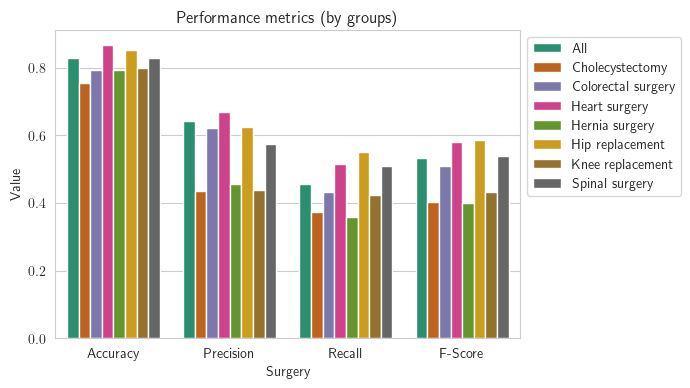

,Surgery,Accuracy,Precision,Recall,F-Score
0,All,0.8292,0.6427,0.4559,0.5334
1,Cholecystectomy,0.7554,0.4359,0.3736,0.4024
2,Colorectal surgery,0.7944,0.6216,0.4315,0.5094
3,Heart surgery,0.8678,0.6678,0.5150,0.5815
4,Hernia surgery,0.7926,0.4545,0.3571,0.4000
5,Hip replacement,0.8516,0.6259,0.5509,0.5860
6,Knee replacement,0.8000,0.4386,0.4237,0.4310
7,Spinal surgery,0.8301,0.5741,0.5082,0.5391


In [15]:
fs = [x for x in listdir(output_path) if x.endswith('.metrics')]
d = {}
for f in fs:
    name = f.split('_')[1]
    name = 'All' if name=='9' else name
    with open(path.join(output_path,f),'r') as F:
        _ = eval(F.readline().strip())
    d[name] = _
D = pd.DataFrame.from_dict(d,orient='index').reset_index()

D.columns = ['Surgery','Accuracy_old','Accuracy','Precision','Recall','F-Score']
D = D[['Surgery','Accuracy','Precision','Recall','F-Score']]
df_melted = D.melt(id_vars='Surgery', var_name='metrics', value_name='values')

sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 4))
sns.barplot(x='metrics', y='values', hue='Surgery', data=df_melted,palette='Dark2')
plt.xlabel('Surgery')
plt.ylabel('Value')
plt.title('Performance metrics (by groups)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
plt.savefig(path.join(output_path,'surgery_metrics.pdf'),bbox_inches='tight', pad_inches=.1)
plt.show()
D.to_csv(path.join(output_path,'surgery_metrics.csv'),index=None)
D

---
# Substitution of HD Matrix

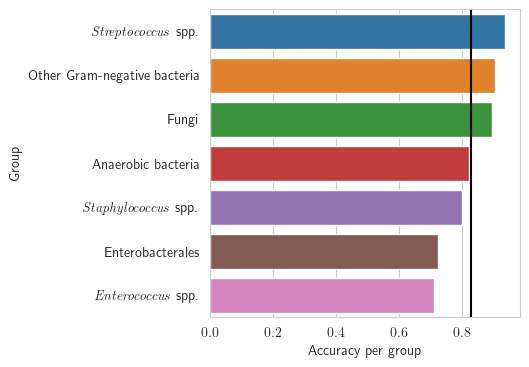

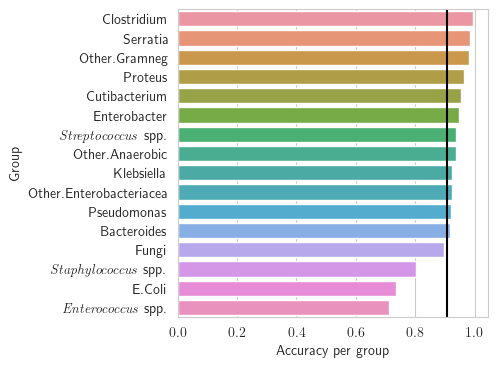

In [43]:
sns.set_style('whitegrid')
def plot_hd_substitute(a,b,output_pdf=None):
    A = a.copy()
    B = b.copy()
    XNOR = np.logical_not(np.logical_xor(A, B)).astype(int)    
    XNOR = pd.DataFrame(XNOR)  
    XNOR.columns = [map_all.get(x.replace('GROUP_','').replace('LABEL_',''),
                                x.replace('GROUP_','').replace('LABEL_','').title()) for x in  XNOR.columns]
    
    # fig,axs = plt.subplots(ncols=2,figsize=(8,4))

    # ax = axs[0]
    fig,ax = plt.subplots(ncols=1,figsize=(4,4))
    sns.barplot(data=XNOR.mean().to_frame().reset_index().sort_values(by=0,ascending=False),y='index',x=0,ax=ax)
    ax.axvline(x=np.mean(XNOR.mean()),color='k')
    ax.set_ylabel('Group')
    ax.set_xlabel('Accuracy per group')

    # ax = axs[1]            
    # s = XNOR.mean(axis=1)
    # thresholds = np.linspace(0, 1, 100)        
    # proportions = [(s >= t).mean() for t in thresholds]
    # ax.plot(thresholds, proportions)
    # ax.invert_xaxis()  # Invert the x-axis to go from 1 to 0
    # ax.set_ylim(0,1)
    # ax.set_xlim(1,0)
    # ax.set_xlabel('Accuracy per individual instance')
    # ax.set_ylabel('Proportion of instances')
    # plt.subplots_adjust(wspace=0.4)

    plt.savefig(output_pdf,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
plot_hd_substitute(y_test_groups,y_groups_pred,'outputs_september/HD_groups.pdf')
plot_hd_substitute(y_test_total,y_total_pred,'outputs_september/HD_bacteria.pdf')

# 5-CV performance

RidgeClassifier
NaiveBayes
DecisionTree
RandomForest
AdaBoost


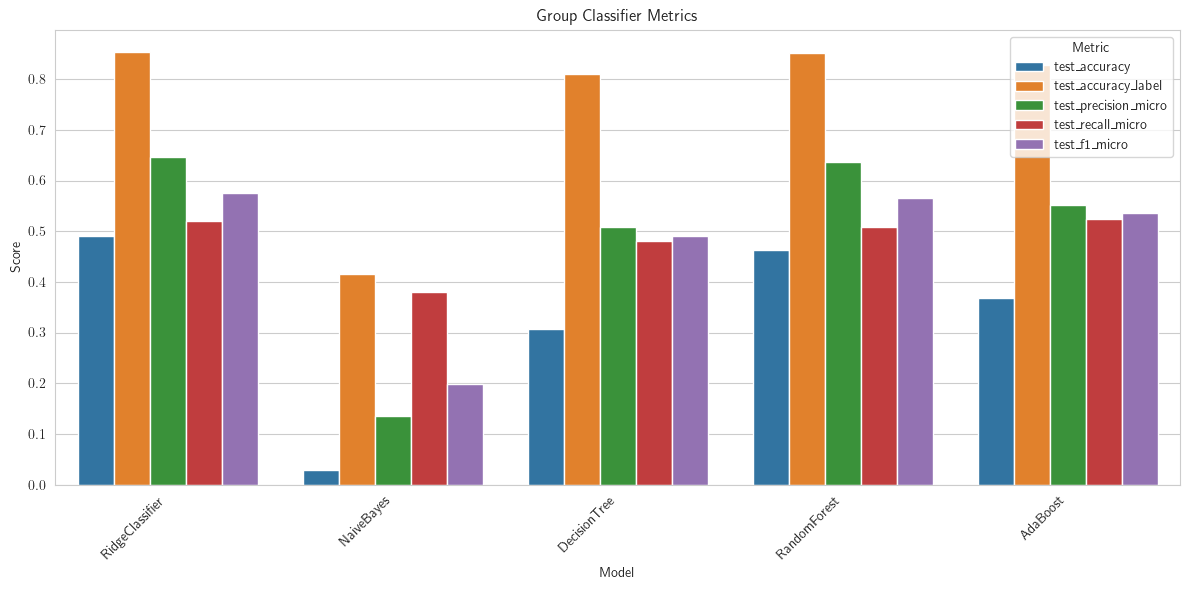

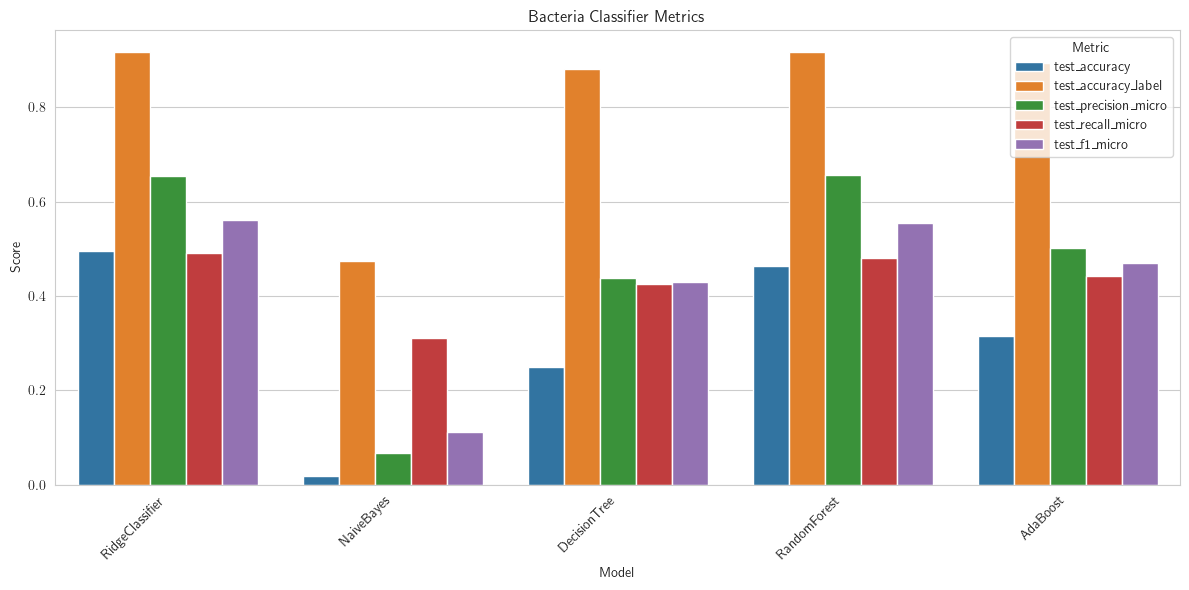

In [35]:
from sklearn.model_selection import cross_validate, KFold

models = [    
    RidgeClassifier(alpha=1,random_state=42),
    GaussianNB(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
]

model_names = { 'GaussianNB':'NaiveBayes',
                'RidgeClassifier':'RidgeClassifier',
                'DecisionTreeClassifier':'DecisionTree',               
               'RandomForestClassifier':'RandomForest',
               'AdaBoostClassifier':'AdaBoost',
               'GaussianNB':'NaiveBayes',
}

scoring = {'accuracy': make_scorer(accuracy_score),
           'accuracy_label': make_scorer(accuracy_label_mean),
           'precision_micro': make_scorer(precision_score, average='micro'),
           'recall_micro': make_scorer(recall_score, average='micro'),
           'f1_micro': make_scorer(f1_score, average='micro'),
           }
R_group = {}
R_bacteria = {}
group = groups_name.split('.')[0]

X_groups_selected = X_train
X_test_groups_selected = X_test
X_total_selected = X_train
X_test_total_selected = X_test


kf = KFold(n_splits=5, random_state=42, shuffle=True)  # 5-fold cross-validation

R_group = {}
R_bacteria = {}

for model in models:
    namex = model_names.get(str(model).split('(')[0], str(model))
    print(namex)

    # Evaluate the classifiers using 5-fold cross-validation on the training set
    group_scores = cross_validate(MultiOutputClassifier(model), X_groups_selected, y_groups, cv=kf, scoring=scoring, return_train_score=True)
    total_scores = cross_validate(MultiOutputClassifier(model), X_total_selected, y_total, cv=kf, scoring=scoring, return_train_score=True)

    R_group[namex] = {metric: np.mean(values) for metric, values in group_scores.items() if 'test_' in metric}
    R_bacteria[namex] = {metric: np.mean(values) for metric, values in total_scores.items() if 'test_' in metric}

# Save the results
pd.DataFrame(R_group).T.reset_index().to_csv(path.join(output_path, 'metrics_group_CV.csv'), float_format='%.2f')
pd.DataFrame(R_bacteria).T.reset_index().to_csv(path.join(output_path, 'metrics_bacteria_CV.csv'), float_format='%.2f')

# Plotting the results
def plot_metrics(metrics_dict, title):
    df = pd.DataFrame(metrics_dict).T
    df = df.reset_index()
    df = pd.melt(df, id_vars='index', var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='index', y='Score', hue='Metric', data=df)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_metrics(R_group, 'Group Classifier Metrics')
plot_metrics(R_bacteria, 'Bacteria Classifier Metrics')

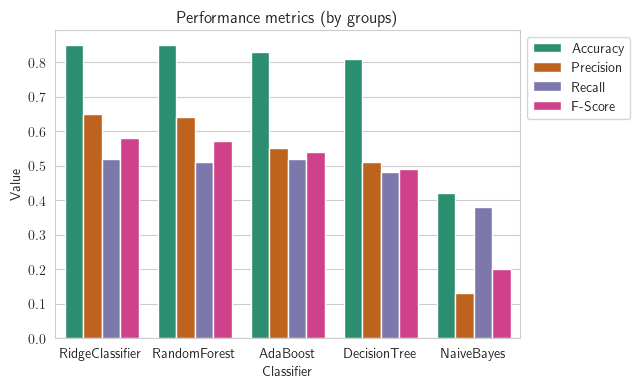

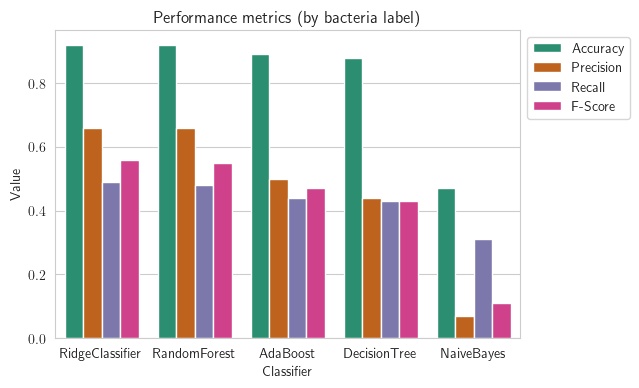

In [38]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'
sns.set_style('whitegrid')
output_pdf = 'outputs_september/metrics_CV.pdf'
pdf = PdfPages(output_pdf)

order = ['AdaBoost','RidgeClassifier','RandomForest', 'NaiveBayes', 'DecisionTree']

df = pd.read_csv(path.join(output_path,'metrics_group_CV.csv'))
del df[df.columns[0]]
df.columns = ['Model','Accuracy_old','Accuracy','Precision','Recall','F-Score']
df = df[['Model','Accuracy','Precision','Recall','F-Score']]
df.sort_values(by=['Accuracy'],ascending=[False],inplace=True)
df_melted = df.melt(id_vars='Model', var_name='metrics', value_name='values')
fig = plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='values', hue='metrics', data=df_melted,palette='Dark2'#,order=order)
plt.xlabel('Classifier')
plt.ylabel('Value')
plt.title('Performance metrics (by groups)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
plt.show()

df = pd.read_csv(path.join(output_path,'metrics_bacteria_CV.csv'))
del df[df.columns[0]]
df.columns = ['Model','Accuracy_old','Accuracy','Precision','Recall','F-Score']
df = df[['Model','Accuracy','Precision','Recall','F-Score']]
df.sort_values(by=['Accuracy'],ascending=[False],inplace=True)
df_melted = df.melt(id_vars='Model', var_name='metrics', value_name='values')
fig = plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='values', hue='metrics', data=df_melted,palette='Dark2')#,order=order)
plt.xlabel('Classifier')
plt.ylabel('Value')
plt.title('Performance metrics (by bacteria label)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
plt.show()

pdf.close()

# Test performance

In [ ]:
models = [    
    RidgeClassifier(alpha=1,random_state=42),
    GaussianNB(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
]

model_names = { 'GaussianNB':'NaiveBayes',
                'RidgeClassifier':'RidgeClassifier',
                'DecisionTreeClassifier':'DecisionTree',               
               'RandomForestClassifier':'RandomForest',
               'AdaBoostClassifier':'AdaBoost',
               'GaussianNB':'NaiveBayes',
}

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision_micro': make_scorer(precision_score, average='micro'),
           'recall_micro': make_scorer(recall_score, average='micro'),
           'f1_micro': make_scorer(f1_score, average='micro'),
           }
R_group = {}
R_bacteria = {}
group = groups_name.split('.')[0]

X_groups_selected = X_train
X_test_groups_selected = X_test
X_total_selected = X_train
X_test_total_selected = X_test
debug_pred = {}
for model in models:    
    namex = model_names.get(str(model).split('(')[0],str(model))    
    print(namex)    
    
    total_classifier = MultiOutputClassifier(model).fit(X_total_selected, y_total)
    group_classifier = MultiOutputClassifier(model).fit(X_groups_selected, y_groups)
    y_total_pred = total_classifier.predict(X_test_total_selected)    
    y_groups_pred = group_classifier.predict(X_test_groups_selected)    
    
    debug_pred[namex] = y_groups_pred
    
    accuracy = accuracy_score(y_test_groups, y_groups_pred)
    precision = precision_score(y_test_groups, y_groups_pred, average='micro')
    recall = recall_score(y_test_groups, y_groups_pred, average='micro')
    f1 = f1_score(y_test_groups, y_groups_pred, average='micro')
    R_group[namex] = {'accuracy':accuracy,
               'precision_micro':precision, 
               'recall_micro':recall, 
               'f1_micro':f1}
    
    accuracy = accuracy_score(y_test_total, y_total_pred)
    precision = precision_score(y_test_total, y_total_pred, average='micro')
    recall = recall_score(y_test_total, y_total_pred, average='micro')
    f1 = f1_score(y_test_total, y_total_pred, average='micro')
    R_bacteria[namex] = {'accuracy':accuracy,
               'precision_micro':precision, 
               'recall_micro':recall, 
               'f1_micro':f1}

pd.DataFrame(R_group).T.reset_index().to_csv(path.join(output_path,'metrics_group.csv'),float_format='%.2f')
pd.DataFrame(R_bacteria).T.reset_index().to_csv(path.join(output_path,'metrics_bacteria.csv'),float_format='%.2f')

In [ ]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'
sns.set_style('whitegrid')
output_pdf = 'outputs_september/metrics.pdf'
pdf = PdfPages(output_pdf)

order = ['AdaBoost','RidgeClassifier','RandomForest', 'NaiveBayes', 'DecisionTree']

df = pd.read_csv(path.join(output_path,'metrics_group.csv'))
del df[df.columns[0]]
df.columns = ['Model','Accuracy','Precision','Recall','F-Score']
df = df[['Model','F-Score','Accuracy','Precision','Recall']]
df.sort_values(by=['F-Score','Accuracy'],ascending=[False,False],inplace=True)
df_melted = df.melt(id_vars='Model', var_name='metrics', value_name='values')
fig = plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='values', hue='metrics', data=df_melted,palette='Dark2',order=order)
plt.xlabel('Classifier')
plt.ylabel('Value')
plt.title('Performance metrics (by groups)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
plt.show()

df = pd.read_csv(path.join(output_path,'metrics_bacteria.csv'))
del df[df.columns[0]]
df.columns = ['Model','Accuracy','Precision','Recall','F-Score']
df = df[['Model','F-Score','Accuracy','Precision','Recall']]
df.sort_values(by=['F-Score','Accuracy'],ascending=[False,False],inplace=True)
df_melted = df.melt(id_vars='Model', var_name='metrics', value_name='values')
fig = plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='values', hue='metrics', data=df_melted,palette='Dark2',order=order)
plt.xlabel('Classifier')
plt.ylabel('Value')
plt.title('Performance metrics (by bacteria label)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
plt.show()

pdf.close()

---
# Importance AdaBoost

In [17]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'

pdf = None
groups_name = 'groups9.csv'
groups_csv = path.join(input_path,groups_name)    
df = pd.read_csv(clean_train_csv)    
dfT = pd.read_csv(clean_test_csv)
df['_id'] = range(len(df))
dfT['_id'] = range(len(dfT))

# df = df[[x for x in df.columns if not x.startswith('ft_surg_')]]
# dfT = dfT[[x for x in dfT.columns if not x.startswith('ft_surg_')]]

cols_ft = [x for x in df.columns if x.startswith('ft_')]
cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
cols_labels_full = list(cols_labels)

print('Full training:',len(df))
df.dropna(inplace=True)
print('dropna training:',len(df))

print('Full test:',len(dfT))
dfT.dropna(inplace=True)
print('dropna test:',len(dfT))

### Load groups
groups = {}
for g,d in pd.read_csv(groups_csv,sep=';').groupby('group'):
    groups['GROUP_'+g] = ['LABEL_'+x for x in d.bacteria]
print(groups)
present_labels = set(sum(list(groups.values()),[]))
all_labels = set(cols_labels)
cols_labels = sorted(present_labels)
print('> Columns to keep:',cols_labels)
print('> Columns to drop:', all_labels-present_labels)
for k,v in groups.items():
    df[k] = (df[v].sum(axis=1)>0).astype(int)
    dfT[k] = (dfT[v].sum(axis=1)>0).astype(int)
cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
df.drop(columns = all_labels-present_labels,inplace=True)
dfT.drop(columns = all_labels-present_labels,inplace=True)

###### Assign groups
df = df[df[cols_groups].sum(axis=1)>0]
dfT = dfT[dfT[cols_groups].sum(axis=1)>0]
print('After groups training:',len(df))
print('After groups test:',len(dfT))
    
X_train = df[cols_ft]
y_total = df[cols_labels]
y_groups = df[cols_groups]
X_test = dfT[cols_ft]
y_test_total = dfT[cols_labels]
y_test_groups = dfT[cols_groups]

n_iterations = 1000

# DataFrames to store feature importances for each bootstrap iteration
feature_importances = np.zeros((n_iterations, X_train.shape[1]))

# Bootstrap procedure
for i in range(n_iterations):
    if i%10==0:
        print('>>>%s'%i)
    # Resample data with replacement
    X_resampled, y_resampled = resample(X_train, y_groups, random_state=i)
    
    # Train AdaBoost model
    model = AdaBoostClassifier(random_state=42)
    multi_output_classifier = MultiOutputClassifier(model).fit(X_resampled, y_resampled)
    
    # Get average feature importance across all classifiers in the multi-output classifier
    avg_importance = np.mean([estimator.feature_importances_ for estimator in multi_output_classifier.estimators_], axis=0)
    feature_importances[i] = avg_importance

Full training: 5239
dropna training: 5239
Full test: 1363
dropna test: 1363
{'GROUP_anaerobic': ['LABEL_cutibacterium', 'LABEL_clostridium', 'LABEL_other.anaerobic', 'LABEL_bacteroides'], 'GROUP_enterobacterales': ['LABEL_e.coli', 'LABEL_klebsiella', 'LABEL_proteus', 'LABEL_serratia', 'LABEL_enterobacter', 'LABEL_other.enterobacteriacea'], 'GROUP_enterococci': ['LABEL_enterococci'], 'GROUP_fungi': ['LABEL_fungi'], 'GROUP_gram.neg': ['LABEL_pseudomonas', 'LABEL_other.gramneg'], 'GROUP_staphylococci': ['LABEL_staphylococci'], 'GROUP_streptococci': ['LABEL_streptococci']}
> Columns to keep: ['LABEL_bacteroides', 'LABEL_clostridium', 'LABEL_cutibacterium', 'LABEL_e.coli', 'LABEL_enterobacter', 'LABEL_enterococci', 'LABEL_fungi', 'LABEL_klebsiella', 'LABEL_other.anaerobic', 'LABEL_other.enterobacteriacea', 'LABEL_other.gramneg', 'LABEL_proteus', 'LABEL_pseudomonas', 'LABEL_serratia', 'LABEL_staphylococci', 'LABEL_streptococci']
> Columns to drop: {'LABEL_other.bacteria', 'LABEL_other.grampo

In [25]:
# Calculate 95% CI for feature importances
output_importance = 'outputs_september/importance_adaboost.csv'

confidence_level = 0.95
lower_percentile = ((1.0-confidence_level)/2.0) * 100
upper_percentile = (confidence_level+((1.0-confidence_level)/2.0)) * 100
lower_bound = np.percentile(feature_importances, lower_percentile, axis=0)
upper_bound = np.percentile(feature_importances, upper_percentile, axis=0)

rows = []
# Print the feature importances CI for each feature
for col, mi, lb, ub in zip(cols_ft, np.mean(feature_importances,axis=0), lower_bound, upper_bound):
    col = col.replace('ft_','')
    print('%s : %.3f, 95%% CI: (%.3f, %.3f)'%(map_all.get(col,col.title()),mi,lb,ub))
    rows.append((map_all.get(col.replace('ft_',''),col.title()),mi,lb,ub))
dx = pd.DataFrame(rows)
dx.columns = ['feature','mean','lb','ub']
dx.to_csv(output_importance,index=None,float_format="%.3f" )

Age : 0.260, 95% CI: (0.209, 0.309)
BMI [kg/m²] : 0.224, 95% CI: (0.177, 0.271)
Duration of surgery : 0.221, 95% CI: (0.180, 0.269)
Asa_1 : 0.007, 95% CI: (0.000, 0.014)
Asa_2 : 0.007, 95% CI: (0.003, 0.014)
Asa_3 : 0.003, 95% CI: (0.000, 0.009)
Asa_4 : 0.008, 95% CI: (0.003, 0.014)
Asa_5 : 0.008, 95% CI: (0.000, 0.014)
Class_Clean : 0.023, 95% CI: (0.014, 0.034)
Class_Clean-Contaminated : 0.005, 95% CI: (0.000, 0.011)
Class_Contaminated : 0.008, 95% CI: (0.003, 0.014)
Class_Dirty/Infected : 0.008, 95% CI: (0.000, 0.014)
Hosp_Size_200-499 : 0.004, 95% CI: (0.000, 0.011)
Hosp_Size_500+ : 0.005, 95% CI: (0.000, 0.009)
Hosp_Size_<200 : 0.005, 95% CI: (0.000, 0.011)
Surg_Cholecystectomy : 0.008, 95% CI: (0.000, 0.014)
Surg_Colorectal Surgery : 0.013, 95% CI: (0.003, 0.023)
Surg_Heart Surgery : 0.005, 95% CI: (0.000, 0.011)
Surg_Hernia Surgery : 0.008, 95% CI: (0.000, 0.014)
Surg_Hip Replacement : 0.013, 95% CI: (0.006, 0.020)
Surg_Knee Replacement : 0.013, 95% CI: (0.009, 0.020)
Surg_Spina

                             feature   mean     lb     ub
0                                Age  0.260  0.209  0.309
1                        BMI [kg/m²]  0.224  0.177  0.271
2                Duration of surgery  0.221  0.180  0.269
3                              Asa_1  0.007  0.000  0.014
4                              Asa_2  0.007  0.003  0.014
5                              Asa_3  0.003  0.000  0.009
6                              Asa_4  0.008  0.003  0.014
7                              Asa_5  0.008  0.000  0.014
8                        Class_Clean  0.023  0.014  0.034
9           Class_Clean-Contaminated  0.005  0.000  0.011
10                Class_Contaminated  0.008  0.003  0.014
11              Class_Dirty/Infected  0.008  0.000  0.014
12                 Hosp_Size_200-499  0.004  0.000  0.011
13                    Hosp_Size_500+  0.005  0.000  0.009
14                    Hosp_Size_<200  0.005  0.000  0.011
15              Surg_Cholecystectomy  0.008  0.000  0.014
16           S

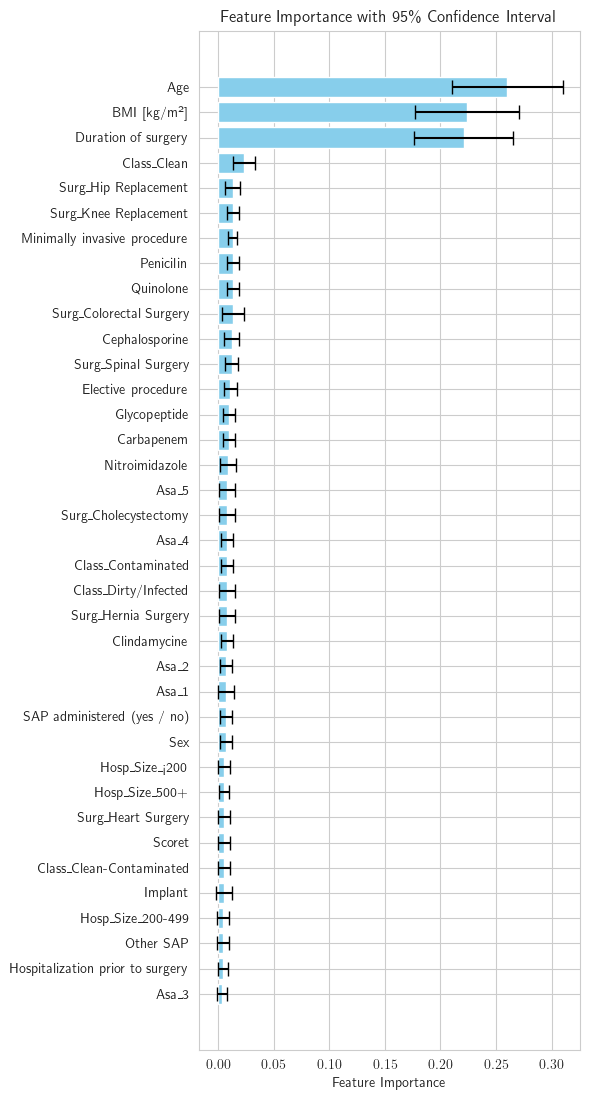

In [26]:
dx = pd.read_csv(output_importance)
print(dx)
# Sorting data by mean importance for better visualization
dx = dx.sort_values(by="mean", ascending=True)

# Plotting
sns.set_style('whitegrid')
plt.figure(figsize=(6, len(dx) * 0.3))  # Adjusting figure size based on number of features
plt.barh(dx['feature'], dx['mean'], xerr=(dx['ub'] - dx['lb']) / 2, color='skyblue', capsize=5)
plt.xlabel('Feature Importance')
plt.title('Feature Importance with 95\% Confidence Interval')
plt.tight_layout()
plt.savefig('outputs_september/importance_adaboost.pdf')
plt.show()

# Plot bootstrap feature importance v2

['age', 'bmi', 'duree', 'class_Clean', 'surg_Colorectal surgery', 'surg_Hip replacement', 'surg_Knee replacement', 'cephalosporin.all', 'surg_Spinal surgery', 'quinolone', 'clindamycine', 'asa_2', 'class_Contaminated', 'class_Dirty/Infected', 'surg_Cholecystectomy', 'carbapenem', 'elective', 'endo_2L', 'nitroimidazole', 'penicillin.all', 'asa_4', 'asa_5', 'glycopeptide', 'SAP.b', 'scoreT', 'asa_1', 'class_Clean-Contaminated', 'hosp_size_200-499', 'hosp_size_500+', 'surg_Heart surgery', 'surg_Hernia surgery', 'implant', 'sex', 'asa_3', 'hosp_size_<200', 'other.SAP2', 'prev.hosp.b']
                             feature      mean
32  Hospitalization prior to surgery  0.000000
30                         Other SAP  0.000000
14                    Hosp_Size_<200  0.002857
5                              Asa_3  0.002857
36                               Sex  0.005714
28                           Implant  0.005714
18               Surg_Hernia Surgery  0.005714
17                Surg_Heart Surgery

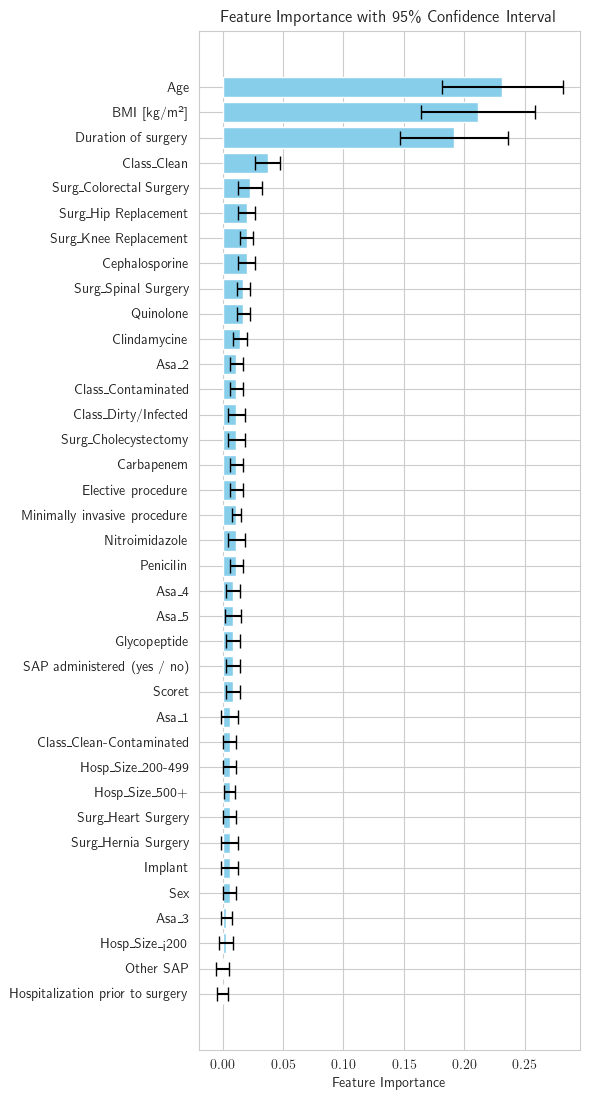

In [27]:
def feature_importance_df(X_train,y_train,X_test,y_test,y_pred,clf,pdf=None,title='',figsize=(10,5),hue_map=None,ft_order=None):
    sns.set_style('white')
    n_features = X_train.shape[1]
    _labels = list(y_train.columns)
    n_labels = len(_labels)
    feature_importances = np.zeros((n_labels, n_features))    
    for i, label in enumerate(_labels):
        estimator = clf.estimators_[i]
        feature_importances[i] = estimator.feature_importances_
    zz = pd.DataFrame(feature_importances)
    zz.columns = [x.replace('ft_','') for x in X_train.columns]
    zz['label'] = [x.replace('LABEL_','').replace('GROUP_','') for x in _labels]    
    if hue_map is None:
        zz['label'] = zz.apply(lambda x:"%s"%(x['label']),axis=1)
    else:
        zz['label'] = zz.apply(lambda x:"%s"%(hue_map.get(x['label'],x['label'])),axis=1)    
    zz.set_index('label',inplace=True)    
    zz = zz.mean().to_frame().reset_index()
    zz.columns = ['feature','mean']
    ft_index = {x:idx for idx,x in enumerate(ft_order)}
    zz['order'] = zz['feature'].map(ft_index)
    zz.sort_values(by='order',ascending=False,inplace=True)
    zz.pop('order')
    zz['feature'] = zz['feature'].apply(lambda x:hue_map.get(x,x.title()))
    return zz

output_importance = 'outputs_september/importance_adaboost.csv'
FINALORDER = list(pd.read_csv('FT_ORDER.txt',header=None)[0])
print(FINALORDER)
dz = feature_importance_df(X_train,y_groups,X_test,y_test_groups,y_groups_pred,group_classifier,
                           title='Groups - Feature importance',pdf=pdf,hue_map=map_all,
                          ft_order=FINALORDER)
print(dz)
dx = pd.read_csv(output_importance)
dx.pop('mean')
dx = pd.merge(dz,dx,sort=False)

# # Plotting
sns.set_style('whitegrid')
plt.figure(figsize=(6, len(dx) * 0.3))  # Adjusting figure size based on number of features
plt.barh(dx['feature'], dx['mean'], xerr=(dx['ub'] - dx['lb']) / 2, color='skyblue', capsize=5)
plt.xlabel('Feature Importance')
plt.title('Feature Importance with 95\% Confidence Interval')
plt.tight_layout()
plt.savefig('outputs_september/importance_adaboost.pdf')
plt.show()

---
# Feature importance Ridge

In [ ]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'

pdf = None

groups_name = 'groups9.csv'
groups_csv = path.join(input_path,groups_name)    
df = pd.read_csv(clean_train_csv)    
dfT = pd.read_csv(clean_test_csv)
df['_id'] = range(len(df))
dfT['_id'] = range(len(dfT))

df = df[[x for x in df.columns if not x.startswith('ft_surg_')]]
dfT = dfT[[x for x in dfT.columns if not x.startswith('ft_surg_')]]

cols_ft = [x for x in df.columns if x.startswith('ft_')]
cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
cols_labels_full = list(cols_labels)

print('Full training:',len(df))
df.dropna(inplace=True)
print('dropna training:',len(df))

print('Full test:',len(dfT))
dfT.dropna(inplace=True)
print('dropna test:',len(dfT))

### Load groups
groups = {}
for g,d in pd.read_csv(groups_csv,sep=';').groupby('group'):
    groups['GROUP_'+g] = ['LABEL_'+x for x in d.bacteria]
print(groups)
present_labels = set(sum(list(groups.values()),[]))
all_labels = set(cols_labels)
cols_labels = sorted(present_labels)
print('> Columns to keep:',cols_labels)
print('> Columns to drop:', all_labels-present_labels)
for k,v in groups.items():
    df[k] = (df[v].sum(axis=1)>0).astype(int)
    dfT[k] = (dfT[v].sum(axis=1)>0).astype(int)
cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
df.drop(columns = all_labels-present_labels,inplace=True)
dfT.drop(columns = all_labels-present_labels,inplace=True)

###### Assign groups
df = df[df[cols_groups].sum(axis=1)>0]
dfT = dfT[dfT[cols_groups].sum(axis=1)>0]
print('After groups training:',len(df))
print('After groups test:',len(dfT))
    
X_train = df[cols_ft]
y_total = df[cols_labels]
y_groups = df[cols_groups]
X_test = dfT[cols_ft]
y_test_total = dfT[cols_labels]
y_test_groups = dfT[cols_groups]

HIGH_VIF = []
X_train2 = X_train.drop(columns=HIGH_VIF)
X_test2 = X_test.drop(columns=HIGH_VIF)

#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

features = list(X_train.columns)
labels_groups = list(y_groups.columns)
labels_total = list(y_total.columns)

# model = LogisticRegression(penalty='l1', solver='liblinear')
model = RidgeClassifier(alpha=1,random_state=42)
total_classifier = MultiOutputClassifier(model).fit(X_train2, y_total)
group_classifier = MultiOutputClassifier(model).fit(X_train2, y_groups)
total_classifier.estimators_

coefs_group = np.array([estimator.coef_ for estimator in group_classifier.estimators_]).squeeze()
coefs_total = np.array([estimator.coef_ for estimator in total_classifier.estimators_]).squeeze()

coef_df = []
for i,estimator in enumerate(coefs_group):
    for j,c in enumerate(estimator):
        coef_df.append(('groups',labels_groups[i],features[j],c))            
for i,estimator in enumerate(coefs_total):
    for j,c in enumerate(estimator):
        coef_df.append(('bacteria',labels_total[i],features[j],c))
            
# #####################
R_group = {}
R_bacteria = {}
group = groups_name.split('.')[0]
namex='LinearRegression'


y_total_pred = total_classifier.predict(X_test2)
y_groups_pred = group_classifier.predict(X_test2)

accuracy = accuracy_score(y_test_groups, y_groups_pred)
precision = precision_score(y_test_groups, y_groups_pred, average='micro')
recall = recall_score(y_test_groups, y_groups_pred, average='micro')
f1 = f1_score(y_test_groups, y_groups_pred, average='micro')
R_group[namex] = {'accuracy':accuracy,
           'precision_micro':precision, 
           'recall_micro':recall, 
           'f1_micro':f1}

accuracy = accuracy_score(y_test_total, y_total_pred)
precision = precision_score(y_test_total, y_total_pred, average='micro')
recall = recall_score(y_test_total, y_total_pred, average='micro')
f1 = f1_score(y_test_total, y_total_pred, average='micro')
R_bacteria[namex] = {'accuracy':accuracy,
           'precision_micro':precision, 
           'recall_micro':recall, 
           'f1_micro':f1}
print('Groups',R_group)
print('Bacteria',R_bacteria)

plot_confusion_matrices(y_test_groups,y_groups_pred,title='',pdf=None,hue_order=None,hue_map=map_all)

## Bootstrap

In [ ]:
n_iterations = 1000  # Number of bootstrap samples to create
r_groups = []
r_total = []
# Run bootstrap
for i in range(n_iterations):
    if i%10==0:
        print(i)
    X_total_resample, y_total_resample = resample(X_train2, y_total)
    X_groups_resample, y_groups_resample = resample(X_train2, y_groups)
    
    model = RidgeClassifier(alpha=1,random_state=42)
    total_classifier2 = MultiOutputClassifier(model).fit(X_total_resample, y_total_resample)
    group_classifier2 = MultiOutputClassifier(model).fit(X_groups_resample, y_groups_resample)

    coefs_group = np.array([estimator.coef_ for estimator in group_classifier2.estimators_]).squeeze()
    coefs_total = np.array([estimator.coef_ for estimator in total_classifier2.estimators_]).squeeze()
    
    r_groups.append(coefs_group)
    r_total.append(coefs_total)
    
intervals = {}
for i in range(len(r_groups[0])):    
    coefficients = np.zeros((n_iterations, X_train2.shape[1]))
    for j in range(len(r_groups)):
        coefficients[j] = r_groups[j][i]
    # # Confidence intervals
    lower = np.percentile(coefficients, 2.5, axis=0)
    upper = np.percentile(coefficients, 97.5, axis=0)
    #_intercept fix
    lower = np.insert(lower,0,0)
    upper = np.insert(upper,0,0)
    intervals[labels_groups[i]] = {'lo':lower,'hi':upper}
for i in range(len(r_total[0])):    
    coefficients = np.zeros((n_iterations, X_train2.shape[1]))
    for j in range(len(r_total)):
        coefficients[j] = r_total[j][i]
    # # Confidence intervals
    lower = np.percentile(coefficients, 2.5, axis=0)
    upper = np.percentile(coefficients, 97.5, axis=0)
    #_intercept fix
    lower = np.insert(lower,0,0)
    upper = np.insert(upper,0,0)
    intervals[labels_total[i]] = {'lo':lower,'hi':upper}
    
rows = []
for i,e in enumerate(group_classifier.estimators_):
    CC = summary(e, X_train2, y_groups.values[:,i],xlabels=list(X_train2.columns),display=False)
    CC['level']='groups'
    CC['name']=labels_groups[i]
    CC['lo'] = intervals[labels_groups[i]]['lo']
    CC['hi'] = intervals[labels_groups[i]]['hi']
    CC.drop(columns = ['Std. Error','t value'], inplace=True)
    rows.append(CC)
        
for i,e in enumerate(total_classifier.estimators_):
    CC = summary(e, X_train2, y_total.values[:,i],xlabels=list(X_train2.columns),display=False)
    CC['level']='bacteria'
    CC['name']=labels_total[i]
    CC['lo'] = intervals[labels_total[i]]['lo']
    CC['hi'] = intervals[labels_total[i]]['hi']
    CC.drop(columns = ['Std. Error','t value'], inplace=True)
    rows.append(CC)
    
coef_df = pd.concat(rows)
coef_df['name'] = coef_df['name'].str.replace('GROUP_','').str.replace('LABEL_','')
coef_df['name'] = coef_df['name'].apply(lambda x:map_all.get(x,x.title()))
coef_df.reset_index(inplace=True)
coef_df.rename(columns={'index':'feature'},inplace=True)
coef_df.sort_values(by=['level','name','Estimate'],ascending=[True,True,False])
output_csv = 'outputs_september/coefficients_ridge.csv'
coef_df.to_csv(output_csv,index=None)

In [ ]:
dc = pd.read_csv('outputs_september/coefficients_ridge.csv')#.sort_values(by='mean',ascending=False)
dd = dc[(dc['level']=='groups')&(dc['feature']!='_intercept')]
dd.loc[dd['p value']>0.05,'Estimate']=0
dd['Estimate'] = np.abs(dd['Estimate'])
P = pd.pivot(dd,index='name',columns='feature',values='Estimate').fillna(0)
p = P.sum(axis=0).to_frame().sort_values(by=0,ascending=False)
FINAL_COLUMNS = list(p.index)
FINAL_COLUMNS


In [ ]:
coef_df = pd.read_csv('outputs_september/coefficients_ridge.csv')
coef_df['feature2'] = pd.Categorical(coef_df['feature'],FINAL_COLUMNS)
coef_df.sort_values('feature2',inplace=True)
coef_df.loc[coef_df['hi']<coef_df['Estimate'],'hi'] = coef_df[coef_df['hi']<coef_df['Estimate']]['Estimate']
coef_df.loc[coef_df['lo']>coef_df['Estimate'],'lo'] = coef_df[coef_df['lo']>coef_df['Estimate']]['Estimate']

output_pdf = 'outputs_september/coefficients_ridge.pdf'
pdf = PdfPages(output_pdf)

sns.set_style('white')

dx = coef_df[(coef_df['feature']!='_intercept')&(coef_df['p value']<=0.05)]
dx['feature'] = dx['feature'].apply(lambda x:map_all.get(x.replace('ft_',''),x.replace('ft_','').title()))
dx['feature3'] = dx['feature2'].apply(lambda x:map_all.get(x.replace('ft_',''),x.replace('ft_','').title()))

dd = dx[dx['level']=='groups']

P = pd.pivot(dd,index='name',columns='feature3',values='Estimate')
fig,ax = plt.subplots(figsize=(8,4))
sns.heatmap(P, cmap='bwr', center=0, cbar_kws={'label': 'Estimate'},ax=ax)
ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=90)
ax.tick_params(axis='y', which='major', labelsize=10, labelleft=True,rotation=0)
ax.set_ylabel('')
plt.suptitle('Significant coefficients for groups',y=1.4,fontsize=14)
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
plt.show()

dd = dx[dx['level']=='bacteria']
P = pd.pivot(dd,index='name',columns='feature3',values='Estimate')
fig,ax = plt.subplots(figsize=(8,4))
sns.heatmap(P, cmap='bwr', center=0, cbar_kws={'label': 'Estimate'},ax=ax)
ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=90)
ax.tick_params(axis='y', which='major', labelsize=10, labelleft=True,rotation=0)
ax.set_ylabel('')
plt.suptitle('Significant coefficients for groups',y=1.4,fontsize=14)
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
plt.show()

sns.set_style('whitegrid')
coef_df.sort_values(by=['level','name','Estimate'],ascending=[True,True,False],inplace=True)
data = coef_df[coef_df['level']=='groups']
order = ['Enterobacterales','Staph.Strept','Other']
for name,data2 in data.groupby('name'):
    print(name)
    data2 = data2[data2['p value']<=0.05].sort_values(by=['Estimate'],ascending=[False])
    # Calculate the errors
    data2['error_lower'] = data2['Estimate'] - data2['lo']
    data2['error_upper'] = data2['hi'] - data2['Estimate']    
    # Create asymmetric error values
    errors = [data2['error_lower'].values, data2['error_upper'].values]    
    
    g = sns.catplot(data=data2,
                    x='Estimate', y='feature', 
                    col='name',
                    col_wrap=1,
                    kind='bar',
                    aspect=.5,                    
                    height=6,
                    xerr=errors,  # Adding error bars
                    capsize=5,color='skyblue')
    for ax in g.axes:
        ax.axvline(0, color='black', linewidth=1.5)  # Bold line at 0
    g.set_titles("")
    # g.axes[0].tick_params(labelsize=4)
    plt.suptitle('Significant coefficients for group %s'%name,y=1)
    pdf.savefig(g.fig,bbox_inches='tight', pad_inches=.1)
    plt.show()    

data = coef_df[coef_df['level']=='bacteria']
for name,data2 in data.groupby('name'):
    print(name)
    data2 = data2[data2['p value']<=0.05].sort_values(by=['Estimate'],ascending=[False])
    data2['error_lower'] = data2['Estimate'] - data2['lo']
    data2['error_upper'] = data2['hi'] - data2['Estimate']        
    errors = [data2['error_lower'].values, data2['error_upper'].values]
    
    g = sns.catplot(data=data2,
                    x='Estimate', y='feature', 
                    col='name',
                    col_wrap=1,
                    kind='bar',
                    aspect=.5,                
                    height=6,xerr=errors,
                    capsize=5,color='skyblue')
    for ax in g.axes:
        ax.axvline(0, color='black', linewidth=1.5)  # Bold line at 0
    g.set_titles("")
    # g.axes[0].tick_params(labelsize=4)
    plt.suptitle('Significant coefficients for bacteria %s'%name,y=1)
    pdf.savefig(g.fig,bbox_inches='tight', pad_inches=.1)
    plt.show()

pdf.close()
print('Done')

---
---
---
# Iterate over features: ADABOOST

In [28]:
# dc = pd.read_csv('outputs_september/importance_adaboost.csv').sort_values(by='mean',ascending=False)

# lowerfirst = lambda s: ((s[:1].lower() + s[1:] if s else '').
#                         replace('scoret','scoreT').
#                         replace('Size','size'))

# dc['ft'] = dc['feature'].apply(lambda x:map_all_inv.get(x,lowerfirst(x)))
# dc['ft'] = 'ft_'+dc['ft']
# FINAL_COLUMNS = list(dc['ft'])

FINALORDER = list(pd.read_csv('FT_ORDER.txt',header=None)[0])
FINAL_COLUMNS = ['ft_%s'%x for x in FINALORDER]
FINAL_COLUMNS

['ft_age',
 'ft_bmi',
 'ft_duree',
 'ft_class_Clean',
 'ft_surg_Colorectal surgery',
 'ft_surg_Hip replacement',
 'ft_surg_Knee replacement',
 'ft_cephalosporin.all',
 'ft_surg_Spinal surgery',
 'ft_quinolone',
 'ft_clindamycine',
 'ft_asa_2',
 'ft_class_Contaminated',
 'ft_class_Dirty/Infected',
 'ft_surg_Cholecystectomy',
 'ft_carbapenem',
 'ft_elective',
 'ft_endo_2L',
 'ft_nitroimidazole',
 'ft_penicillin.all',
 'ft_asa_4',
 'ft_asa_5',
 'ft_glycopeptide',
 'ft_SAP.b',
 'ft_scoreT',
 'ft_asa_1',
 'ft_class_Clean-Contaminated',
 'ft_hosp_size_200-499',
 'ft_hosp_size_500+',
 'ft_surg_Heart surgery',
 'ft_surg_Hernia surgery',
 'ft_implant',
 'ft_sex',
 'ft_asa_3',
 'ft_hosp_size_<200',
 'ft_other.SAP2',
 'ft_prev.hosp.b']

In [ ]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'

R_groups = {}
R_bacteria = {}
pdf = None

df = pd.read_csv(clean_train_csv)
dfT = pd.read_csv(clean_test_csv)

df['_id'] = range(len(df))
dfT['_id'] = range(len(dfT))
# df = df[[x for x in df.columns if not x.startswith('ft_surg_')]]
# dfT = dfT[[x for x in dfT.columns if not x.startswith('ft_surg_')]]

cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
cols_labels_full = list(cols_labels)

print('Full training:',len(df))
df.dropna(inplace=True)
print('dropna training:',len(df))

print('Full test:',len(dfT))
dfT.dropna(inplace=True)
print('dropna test:',len(dfT))

### Load groups
groups = {}
for g,d in pd.read_csv(groups_csv,sep=';').groupby('group'):
    groups['GROUP_'+g] = ['LABEL_'+x for x in d.bacteria]
print(groups)
present_labels = set(sum(list(groups.values()),[]))
all_labels = set(cols_labels)
cols_labels = sorted(present_labels)
print('> Columns to keep:',cols_labels)
print('> Columns to drop:', all_labels-present_labels)
for k,v in groups.items():
    df[k] = (df[v].sum(axis=1)>0).astype(int)
    dfT[k] = (dfT[v].sum(axis=1)>0).astype(int)
cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
df.drop(columns = all_labels-present_labels,inplace=True)
dfT.drop(columns = all_labels-present_labels,inplace=True)
###### Assign groups
df = df[df[cols_groups].sum(axis=1)>0]
dfT = dfT[dfT[cols_groups].sum(axis=1)>0]
print('After groups training:',len(df))
print('After groups test:',len(dfT))

for bb in range(1,len(FINAL_COLUMNS)+1):
    cols_ft = FINAL_COLUMNS[:bb]
    fig,ax = plt.subplots(figsize=(5,5))
    ax.text(0.5,0.5,','.join(cols_ft),ha='center',va='center',fontsize=22,color='red')
    ax.axis('off')
    plt.show()
    plt.close('all')

    ### Train models
    X_train = df[cols_ft]
    y_total = df[cols_labels]
    y_groups = df[cols_groups]
    X_test = dfT[cols_ft]
    y_test_total = dfT[cols_labels]
    y_test_groups = dfT[cols_groups]

    model = AdaBoostClassifier(random_state=42)    
    total_classifier = MultiOutputClassifier(model).fit(X_train, y_total)
    group_classifier = MultiOutputClassifier(model).fit(X_train, y_groups)
    y_total_pred = total_classifier.predict(X_test)
    y_total_prob = total_classifier.predict_proba(X_test)
    y_groups_pred = group_classifier.predict(X_test)
    y_groups_prob = group_classifier.predict_proba(X_test)

    pretty_groups = [x.replace('GROUP_','') for x in y_groups.columns]
    pretty_bacteria = [x.replace('LABEL_','') for x in y_total.columns]

    map_labels = {}
    fpr = dict()
    tpr = dict()
    roc_auc_bacteria = dict()
    zz = []
    for i,label in enumerate(pretty_bacteria):
        fpr[i], tpr[i], _ = roc_curve(y_test_total.values[:, i], y_total_prob[i][:, 1])
        _auc = np.round(auc(fpr[i], tpr[i]),2)
        roc_auc_bacteria[label.replace('LABEL_','').replace('GROUP_','')] = _auc
        zz.append((i,_auc))
    print(roc_auc_bacteria)

    fpr = dict()
    tpr = dict()
    roc_auc_groups = dict()
    zz = []
    for i,label in enumerate(pretty_groups):
        fpr[i], tpr[i], _ = roc_curve(y_test_groups.values[:, i], y_groups_prob[i][:, 1])
        _auc = np.round(auc(fpr[i], tpr[i]),2)
        roc_auc_groups[label.replace('LABEL_','').replace('GROUP_','')] = _auc
        zz.append((i,_auc))
    print(roc_auc_groups)

    R_groups[bb] = roc_auc_groups
    R_bacteria[bb] = roc_auc_bacteria

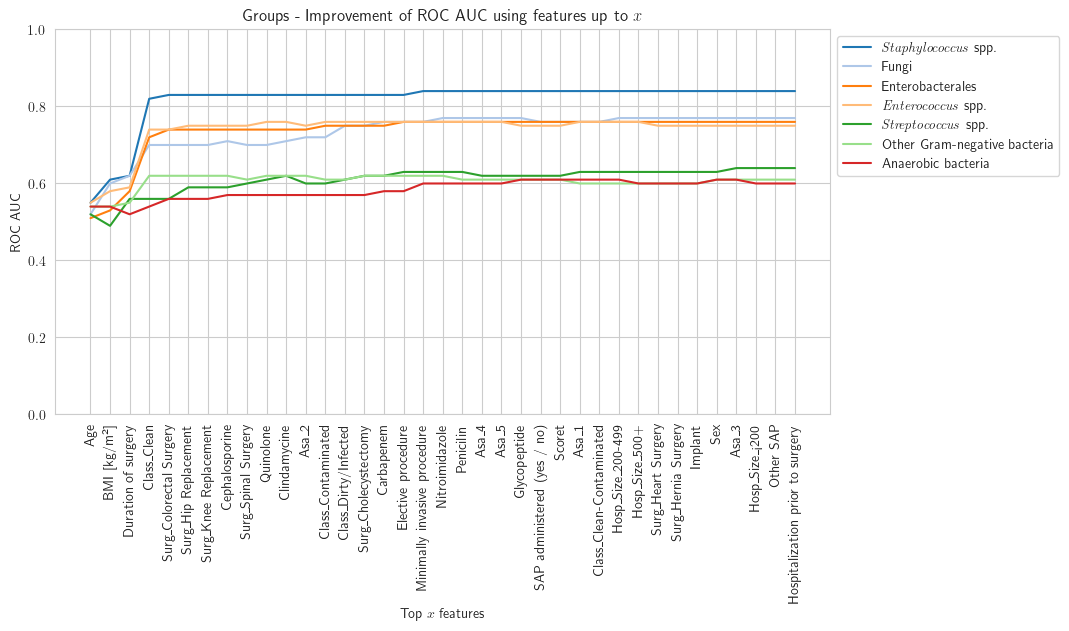

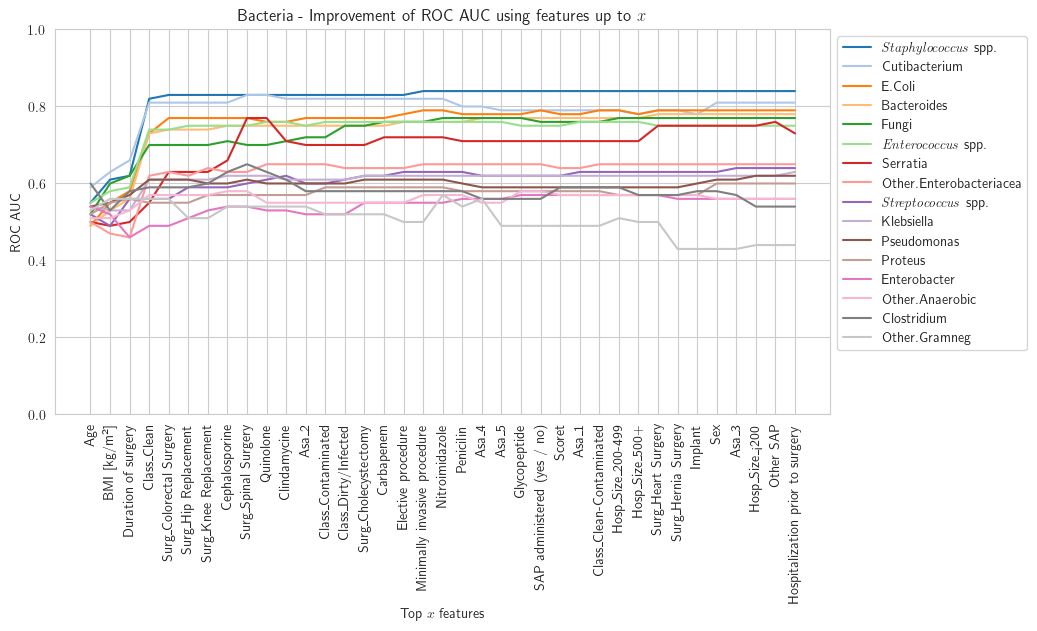

In [30]:
roc_groups = pd.DataFrame.from_dict(R_groups,orient='index').reset_index().rename(columns={'index':'features'})
roc_bacteria = pd.DataFrame.from_dict(R_bacteria,orient='index').reset_index().rename(columns={'index':'features'})
pretty_features = [map_all.get(x.replace('ft_',''),x.replace('ft_','').title()) for x in FINAL_COLUMNS]

output_pdf = 'outputs_september/progressive_adaboost.pdf'
pdf = PdfPages(output_pdf)

x = roc_groups['features']
y_columns = list(roc_groups.columns[1:])
y_columns.sort(key=lambda x:-roc_auc_groups[x])
sns.set_style('whitegrid')
sns.set_palette('tab20')
fig,ax = plt.subplots(figsize=(10,5))
for i, column in enumerate(y_columns):
    plt.plot(x, roc_groups[column], label=map_all.get(column,column.title()))
plt.xlabel('Top $x$ features')
plt.ylabel('ROC AUC')
plt.title('Groups - Improvement of ROC AUC using features up to $x$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(x, pretty_features, rotation=90)
plt.ylim(0,1)
plt.show()
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)

x = roc_bacteria['features']
y_columns = list(roc_bacteria.columns[1:])
y_columns.sort(key=lambda x:-roc_auc_bacteria[x])
sns.set_style('whitegrid')
sns.set_palette('tab20')
fig,ax = plt.subplots(figsize=(10,5))
for i, column in enumerate(y_columns):
    plt.plot(x, roc_bacteria[column], label=map_all.get(column,column.title()))
plt.xlabel('Top $x$ features')
plt.ylabel('ROC AUC')
plt.title('Bacteria - Improvement of ROC AUC using features up to $x$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(x, pretty_features, rotation=90)
plt.ylim(0,1)
plt.show()
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)

pdf.close()

roc_groups.to_csv(path.join(output_path,'progressive_adaboost_groups.csv'),index=None)
roc_bacteria.to_csv(path.join(output_path,'progressive_adaboost_bacteria.csv'),index=None)
with open(path.join(output_path,'progressive_adaboost_features.txt'),'w') as f:
    f.write('\n'.join(pretty_features))

---
---
---
# Iterate over features: RIDGECLASSIFIER

In [ ]:
dc = pd.read_csv('outputs_september/coefficients_ridge.csv')#.sort_values(by='mean',ascending=False)
dd = dc[(dc['level']=='groups')&(dc['feature']!='_intercept')]
dd.loc[dd['p value']>0.05,'Estimate']=0
dd['Estimate'] = np.abs(dd['Estimate'])
P = pd.pivot(dd,index='name',columns='feature',values='Estimate').fillna(0)
p = P.sum(axis=0).to_frame().sort_values(by=0,ascending=False)
FINAL_COLUMNS = list(p.index)
FINAL_COLUMNS

In [ ]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'

R_groups = {}
R_bacteria = {}
pdf = None

df = pd.read_csv(clean_train_csv)
dfT = pd.read_csv(clean_test_csv)

df['_id'] = range(len(df))
dfT['_id'] = range(len(dfT))
df = df[[x for x in df.columns if not x.startswith('ft_surg_')]]
dfT = dfT[[x for x in dfT.columns if not x.startswith('ft_surg_')]]

cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
cols_labels_full = list(cols_labels)

print('Full training:',len(df))
df.dropna(inplace=True)
print('dropna training:',len(df))

print('Full test:',len(dfT))
dfT.dropna(inplace=True)
print('dropna test:',len(dfT))

### Load groups
groups = {}
for g,d in pd.read_csv(groups_csv,sep=';').groupby('group'):
    groups['GROUP_'+g] = ['LABEL_'+x for x in d.bacteria]
print(groups)
present_labels = set(sum(list(groups.values()),[]))
all_labels = set(cols_labels)
cols_labels = sorted(present_labels)
print('> Columns to keep:',cols_labels)
print('> Columns to drop:', all_labels-present_labels)
for k,v in groups.items():
    df[k] = (df[v].sum(axis=1)>0).astype(int)
    dfT[k] = (dfT[v].sum(axis=1)>0).astype(int)
cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
df.drop(columns = all_labels-present_labels,inplace=True)
dfT.drop(columns = all_labels-present_labels,inplace=True)
###### Assign groups
df = df[df[cols_groups].sum(axis=1)>0]
dfT = dfT[dfT[cols_groups].sum(axis=1)>0]
print('After groups training:',len(df))
print('After groups test:',len(dfT))

for bb in range(1,len(FINAL_COLUMNS)+1):
    cols_ft = FINAL_COLUMNS[:bb]
    fig,ax = plt.subplots(figsize=(5,5))
    ax.text(0.5,0.5,','.join(cols_ft),ha='center',va='center',fontsize=22,color='red')
    ax.axis('off')
    plt.show()
    plt.close('all')

    ### Train models
    X_train = df[cols_ft]
    y_total = df[cols_labels]
    y_groups = df[cols_groups]
    X_test = dfT[cols_ft]
    y_test_total = dfT[cols_labels]
    y_test_groups = dfT[cols_groups]

    model = RidgeClassifier(random_state=42)   
    total_classifier = MultiOutputClassifier(model).fit(X_train, y_total)
    group_classifier = MultiOutputClassifier(model).fit(X_train, y_groups)
    y_total_pred = total_classifier.predict(X_test)
    y_total_decision = np.array([estimator.decision_function(X_test) for estimator in total_classifier.estimators_]).T
    y_groups_pred = group_classifier.predict(X_test)
    y_groups_decision = np.array([estimator.decision_function(X_test) for estimator in group_classifier.estimators_]).T

    pretty_groups = [x.replace('GROUP_','') for x in y_groups.columns]
    pretty_bacteria = [x.replace('LABEL_','') for x in y_total.columns]

    map_labels = {}
    fpr = dict()
    tpr = dict()
    roc_auc_bacteria = dict()
    zz = []
    for i, label in enumerate(pretty_bacteria):
        fpr[i], tpr[i], _ = roc_curve(y_test_total.values[:, i], y_total_decision[:, i])
        _auc = np.round(auc(fpr[i], tpr[i]), 2)
        roc_auc_bacteria[label.replace('LABEL_', '').replace('GROUP_', '')] = _auc
        zz.append((i, _auc))
    print(roc_auc_bacteria)
    
    fpr = dict()
    tpr = dict()
    roc_auc_groups = dict()
    zz = []
    for i, label in enumerate(pretty_groups):
        fpr[i], tpr[i], _ = roc_curve(y_test_groups.values[:, i], y_groups_decision[:, i])
        _auc = np.round(auc(fpr[i], tpr[i]), 2)
        roc_auc_groups[label.replace('LABEL_', '').replace('GROUP_', '')] = _auc
        zz.append((i, _auc))
    print(roc_auc_groups)

    R_groups[bb] = roc_auc_groups
    R_bacteria[bb] = roc_auc_bacteria

In [ ]:
roc_groups = pd.DataFrame.from_dict(R_groups,orient='index').reset_index().rename(columns={'index':'features'})
roc_bacteria = pd.DataFrame.from_dict(R_bacteria,orient='index').reset_index().rename(columns={'index':'features'})
pretty_features = [map_all.get(x.replace('ft_',''),x.replace('ft_','').title()) for x in FINAL_COLUMNS]

output_pdf = 'outputs_september/progressive_ridge.pdf'
pdf = PdfPages(output_pdf)

x = roc_groups['features']
y_columns = list(roc_groups.columns[1:])
y_columns.sort(key=lambda x:-roc_auc_groups[x])
sns.set_style('whitegrid')
sns.set_palette('tab20')
fig,ax = plt.subplots(figsize=(10,5))
for i, column in enumerate(y_columns):
    plt.plot(x, roc_groups[column], label=map_all.get(column,column.title()))
plt.xlabel('Top $x$ features')
plt.ylabel('ROC AUC')
plt.title('Groups - Improvement of ROC AUC using features up to $x$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(x, pretty_features, rotation=90)
plt.ylim(0,1)
plt.show()
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)

x = roc_bacteria['features']
y_columns = list(roc_bacteria.columns[1:])
y_columns.sort(key=lambda x:-roc_auc_bacteria[x])
sns.set_style('whitegrid')
sns.set_palette('tab20')
fig,ax = plt.subplots(figsize=(10,5))
for i, column in enumerate(y_columns):
    plt.plot(x, roc_bacteria[column], label=map_all.get(column,column.title()))
plt.xlabel('Top $x$ features')
plt.ylabel('ROC AUC')
plt.title('Bacteria - Improvement of ROC AUC using features up to $x$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(x, pretty_features, rotation=90)
plt.ylim(0,1)
plt.show()
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)

pdf.close()

roc_groups.to_csv(path.join(output_path,'progressive_ridge_groups.csv'),index=None)
roc_bacteria.to_csv(path.join(output_path,'progressive_ridge_bacteria.csv'),index=None)
with open(path.join(output_path,'progressive_ridge_features.txt'),'w') as f:
    f.write('\n'.join(pretty_features))

---
---
---
# Predict surgery type

---
---
---
# PDP